In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [216]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict(), dict()]
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = glob.glob(model_dir + "/**/radar_index.pickle", recursive = True)[0]
        with open(file, 'rb') as f:
            radar_idx[m] = pickle.load(f)
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_mtr_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att, radar_idx

In [299]:
def compare_fluxes(radar_index, fluxes_model, fluxes_radar, trial=0, context=0, src=5, dst=6):

    f_model = torch.cat([f for f in fluxes_model[trial].values()], dim=-1)
    f_model[~radar_index] = np.nan
    f_model[:, ~radar_index] = np.nan
    f_model = (f_model - f_model.permute(1, 0, 2))
    f_radar = torch.cat([f[..., context:] for f in fluxes_radar[trial].values()], dim=-1)

    
    f_model = f_model[..., 1:]
    f_radar = f_radar[..., :-1]
    
    idx = np.where(f_model.detach().numpy()!=0)
    diff = (f_model - f_radar).detach().numpy()
    print((diff[idx]**2).mean())
    
    fig, ax = plt.subplots(figsize=(18,5))
    ax.plot(f_radar[src,dst,:].detach().numpy(), label='radar', alpha=0.5)
    ax.plot(f_model[src,dst,:].detach().numpy(), label='model', alpha=0.5)
    ax.legend()

    fig, ax = plt.subplots(figsize=(8,8))
    fr = f_radar.detach().numpy()
    fm = f_model.detach().numpy()
    mask = np.where(np.isfinite(fm))
    ax.scatter(fr.flatten(), fm.flatten(), alpha=0.2)
    ax.set(xlabel='radar fluxes', ylabel='model fluxes');
    return fig

In [303]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM'):

    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [289]:
def plot_net_fluxes(voronoi, G, fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM', compute_net=True):
    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val1 = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            if compute_net:
                val = val1 - val2
            else:
                val = val1
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                #if not boundary1 and not boundary2:
#                     print(val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred net fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [7]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

### With fixed boundary radars, with weighted fluxes

In [298]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'fixed_boundary_without_dummy_radars_encoder_weighted_fluxes']
results0, bird_scales0, fluxes0, _, _ = load_results(models, experiments, base_dir)

5


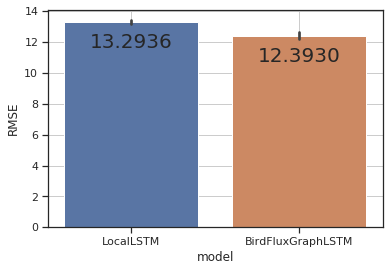

In [98]:
fig = utils.plot_average_errors(results0, boundary=boundary, night_only=True)

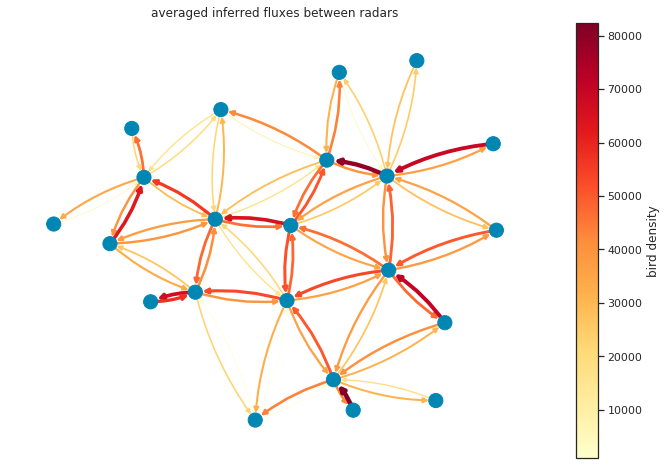

In [304]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_fixed_boundary_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

nan


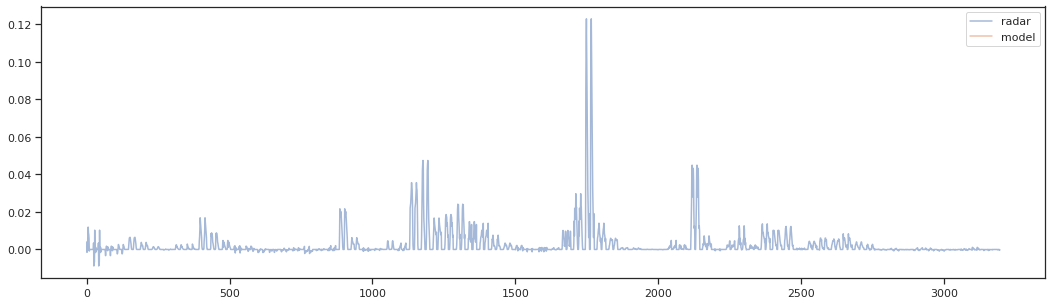

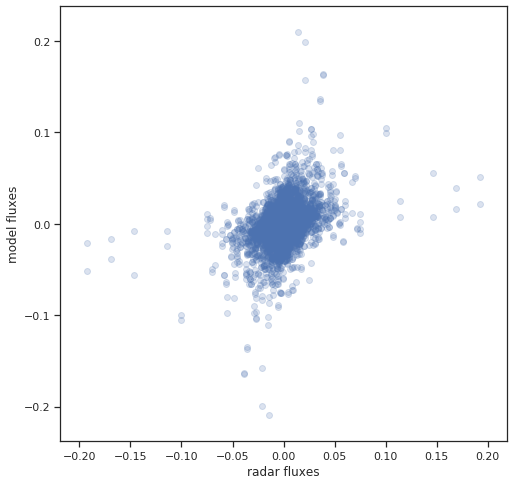

In [301]:
fig = compare_fluxes(inner_radars, fluxes0[0], fluxes0[1], trial=0, context=24, src=10, dst=9)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/scatter_net_fluxes_fixed_boundary_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

In [171]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'fixed_boundary_without_dummy_radars_constrained_fluxes10_encoder_weighted_fluxes_batch4']
results01, bird_scales01, fluxes01, _, _ = load_results(models, experiments, base_dir)

1


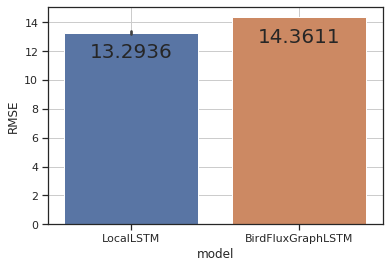

In [172]:
fig = utils.plot_average_errors(results01, boundary=boundary, night_only=True)

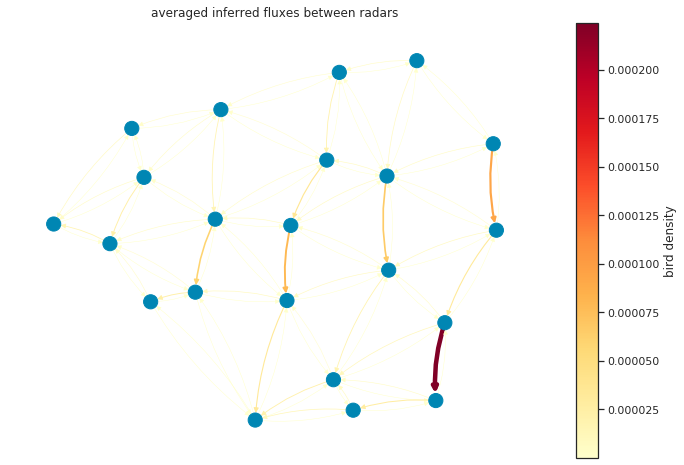

In [173]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes01[0], results01, trial=0, encoder=1, bird_scales=bird_scales01)

(array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  7,  7,  7,  7,  7,
        9,  9,  9,  9,  9, 10, 10, 10, 13, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16,
       20]), array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 13, 13, 13, 13, 17, 17,
       15, 15, 15, 15, 15,  9,  9,  9,  1,  0,  0, 10, 10, 10, 10, 21, 21,
       21, 

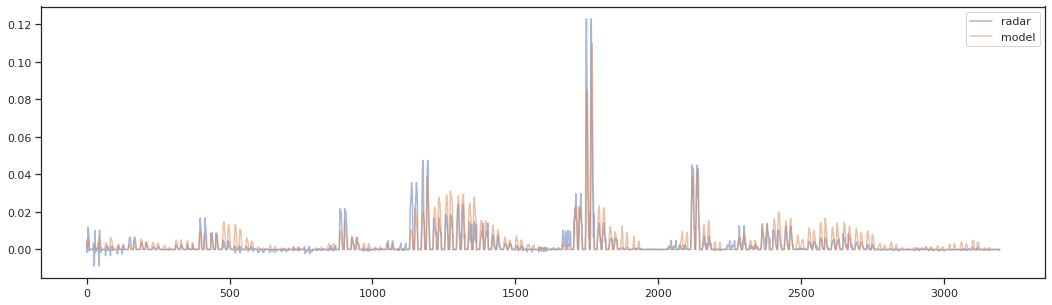

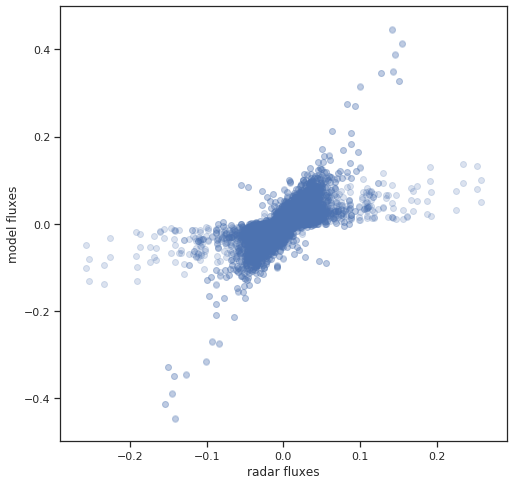

In [147]:
compare_fluxes(voronoi.index.values, fluxes01[0], fluxes01[1], trial=0, context=24, src=10, dst=9)

### Without dummy radars, with weighted fluxes, $c=1.0$

In [201]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_boundary_fluxes1_encoder_weighted_fluxes_batch4']
results1, bird_scales1, fluxes1, _ ,ridx = load_results(models, experiments, base_dir)

1


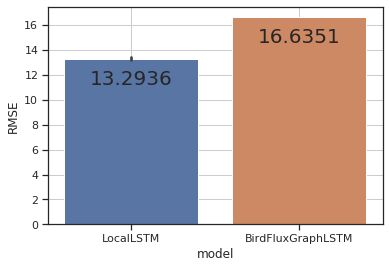

In [185]:
fig = utils.plot_average_errors(results1, boundary=boundary, night_only=True)

In [202]:
ridx

{'LocalLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'},
 'BirdFluxGraphLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'}}

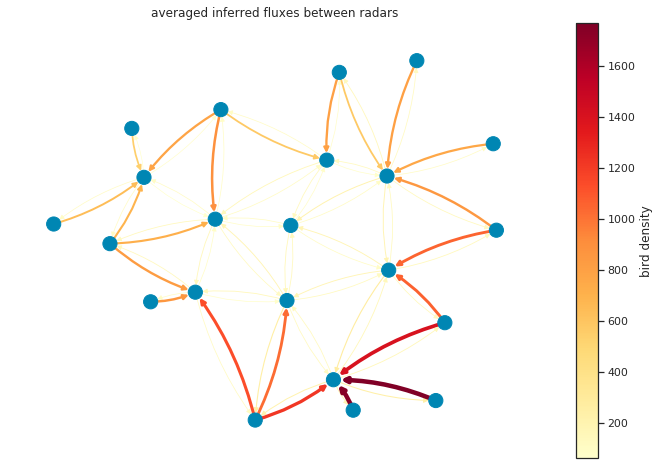

In [187]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes1[0], results1, trial=0, encoder=1, bird_scales=bird_scales1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


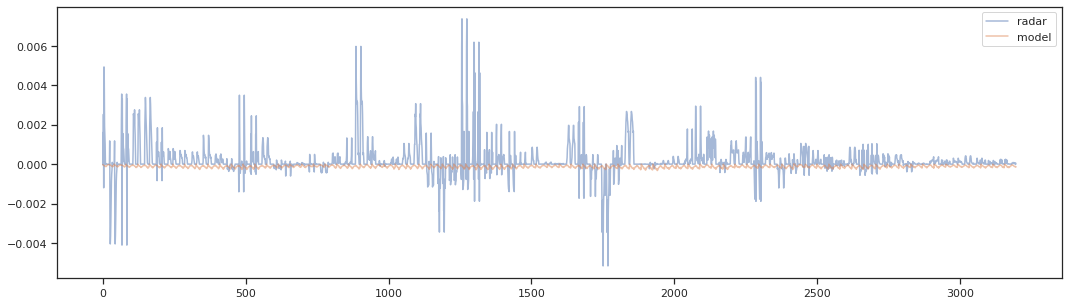

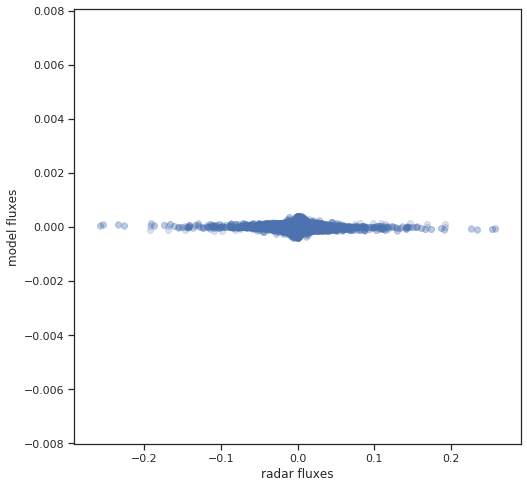

In [204]:
compare_fluxes(voronoi.index.values, fluxes1[0], fluxes1[1], trial=0, context=24, src=9, dst=18)

In [197]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes05_encoder_batch4_n_hidden64']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


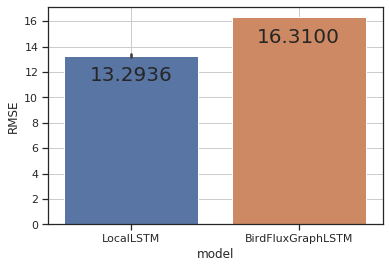

In [199]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

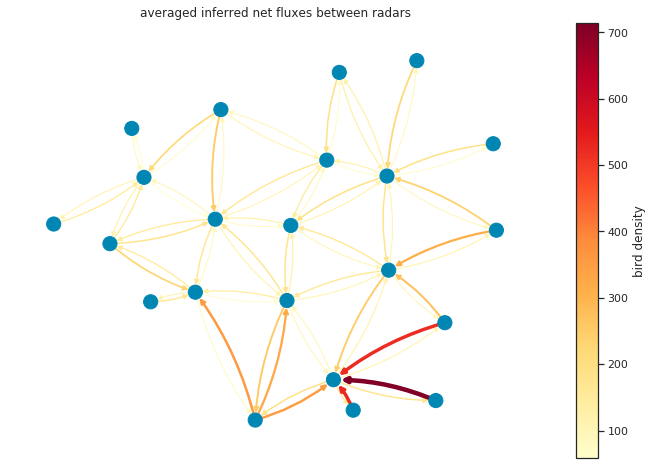

In [198]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_net_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM', compute_net=False)

In [282]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes01_encoder_batch4_n_hidden128']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


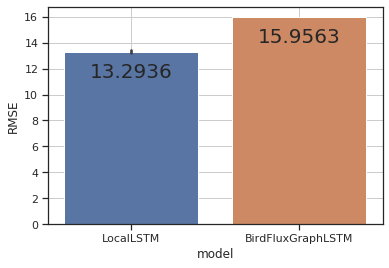

In [286]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

In [287]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

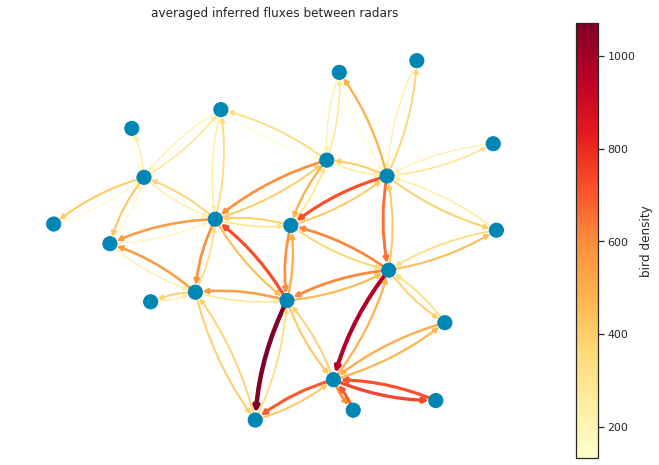

In [290]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

4.135249032745314e-05


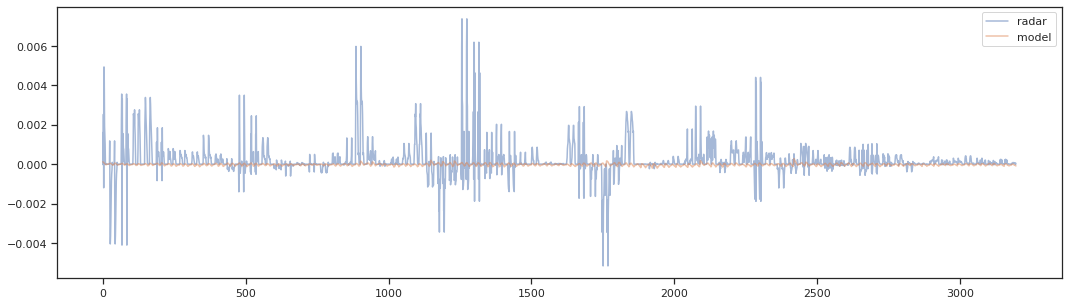

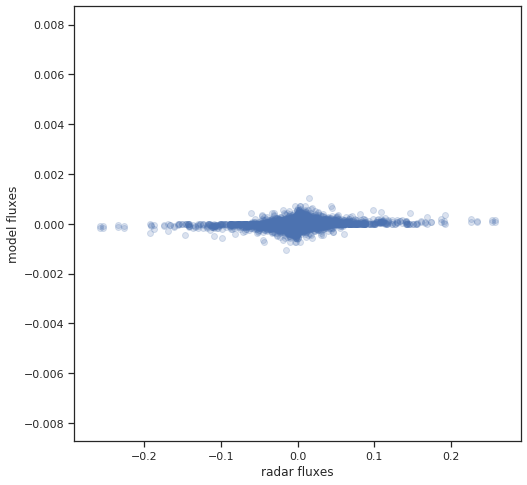

In [292]:
fig = compare_fluxes(voronoi.index.values, fluxes2[0], fluxes2[1], trial=0, context=24, src=9, dst=18)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/scatter_net_fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

In [177]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlptanh_without_dummy_radars_constrained_fluxes10_encoder_weighted_fluxes_batch4']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


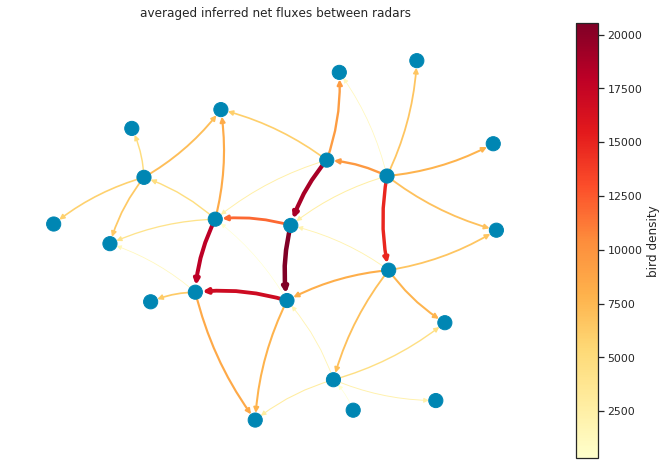

In [179]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_net_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM', compute_net=False)

### Without dummy radars, without weighted fluxes, $c=100.0$

In [293]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes01_encoder_batch4_n_hidden128']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


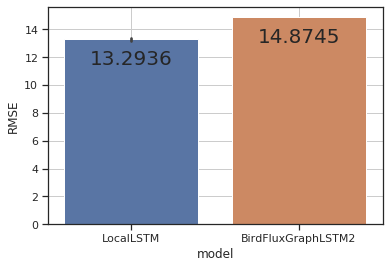

In [294]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

In [295]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_boundary_mlp_contraint01.png', bbox_inches='tight', dpi=300)

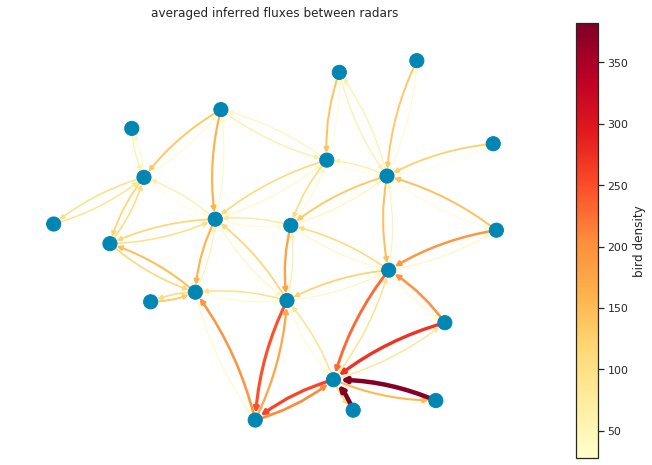

In [296]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM2')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

In [165]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes10_encoder_batch4']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


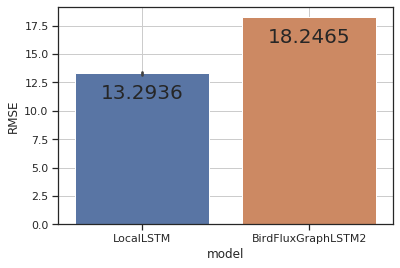

In [166]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

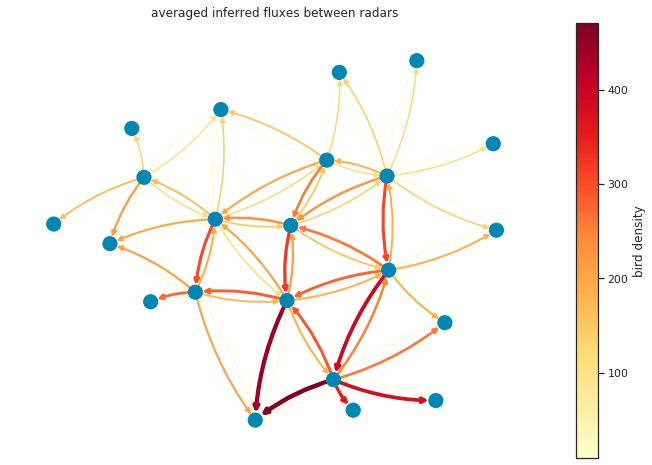

In [167]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM2')

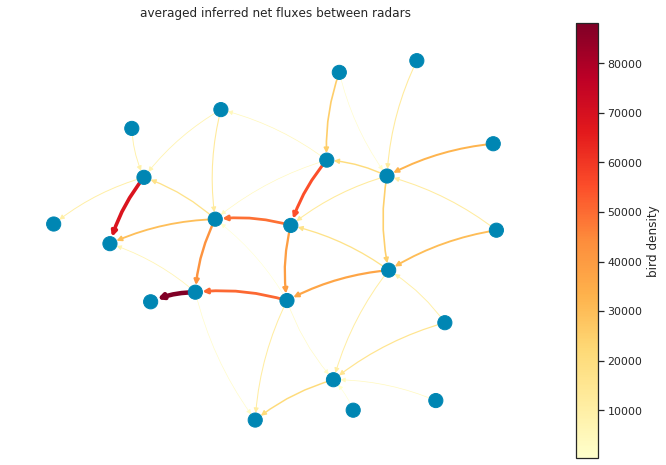

In [163]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_net_fluxes(voronoi, G, fluxes2[1], results2, trial=0, encoder=1, context=24, bird_scales=bird_scales2, m='BirdFluxGraphLSTM2', compute_net=False)

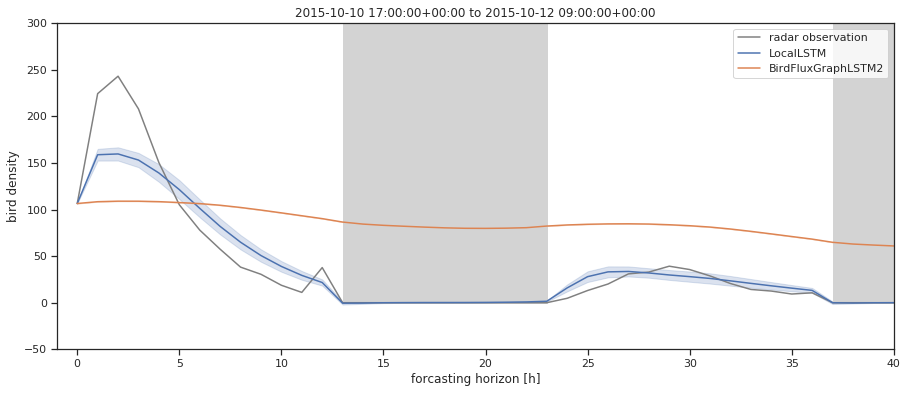

In [191]:
fig = utils.plot_example_prediction(results2, 'defld', 44, max=300, min=-50)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


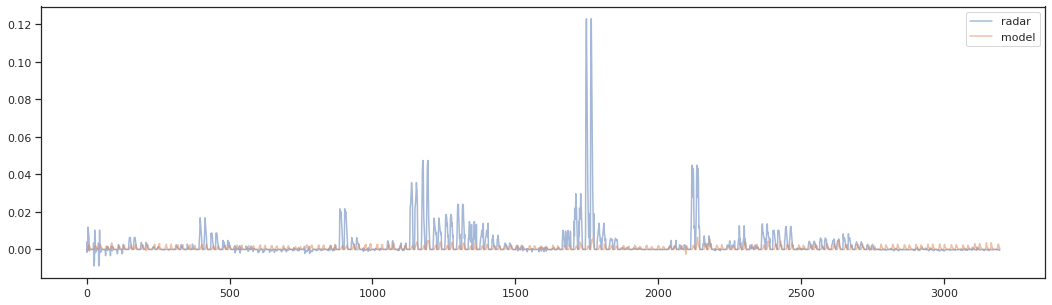

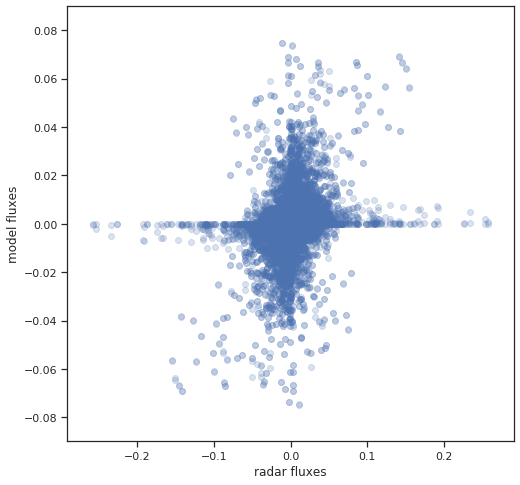

In [136]:
compare_fluxes(voronoi.index.values, fluxes2[0], fluxes2[1], trial=0, context=24, src=10, dst=9)

### With dummy radars, with weighted fluxes, $c=1.0$

In [148]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_fluxmlp_with_dummy_radars_constrained_fluxes10_encoder']
results3, bird_scales3, fluxes3, _, _ = load_results(models, experiments, base_dir)

1


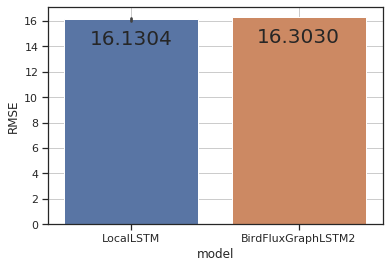

In [149]:
fig = utils.plot_average_errors(results3, boundary=[], night_only=True)

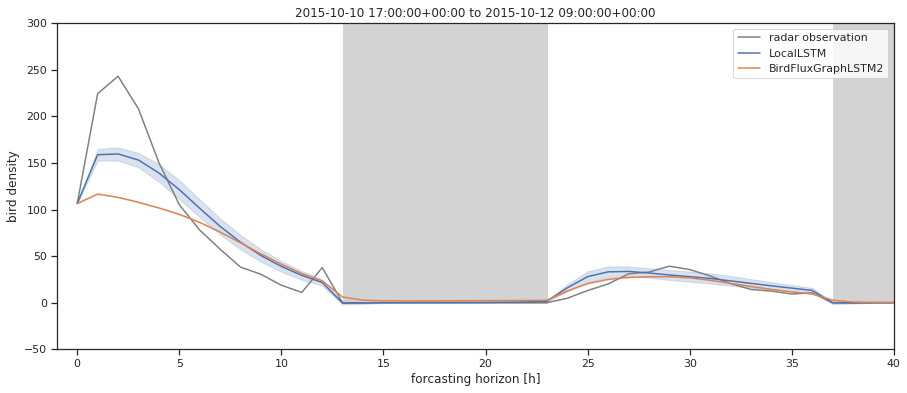

In [154]:
fig = utils.plot_example_prediction(results3, 'defld', 44, max=300, min=-50)

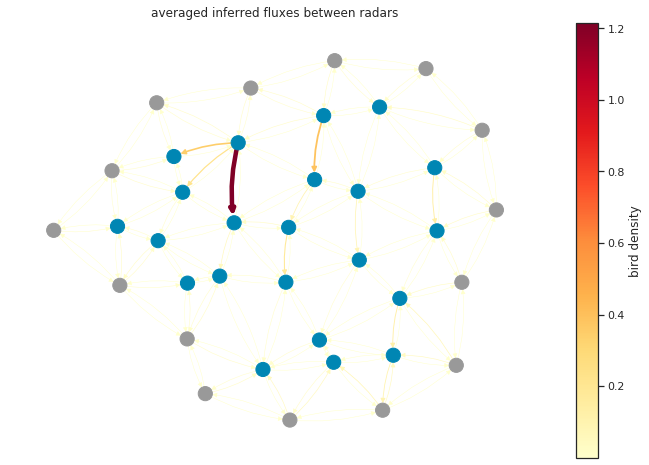

In [151]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[0], results3, trial=0, encoder=1, bird_scales=bird_scales3, m='BirdFluxGraphLSTM2')

nldbl bezav -0.010733793947904588 0.010733793947904592
nldbl bejab -0.0007476476333726392 0.0007476476333726391
nldbl deess 0.0027321226196147163 -0.0027321226196147163
nldbl deemd 0.0011664797968285743 -0.0011664797968285743
nldbl nldhl 0.0011495142144352375 -0.001149514214435234
nldbl boundary_0 -0.000945740192185645 0.000945740192185646
dehnr defld -0.008574432907925764 0.008574432907925764
dehnr deess -0.0006023749544213362 0.0006023749544213363
dehnr deboo 0.003994369374264542 -0.0039943693742645415
dehnr deemd -0.0007495784052392876 0.0007495784052392907
dehnr deumd 0.0032653458708152864 -0.003265345870815287
deneu defld -0.0027530398932298045 0.0027530398932298045
deneu deeis 0.0015700062052968532 -0.0015700062052968536
deneu dedrs 0.004746424466824787 -0.004746424466824787
deneu deoft -0.005834016747553875 0.005834016747553875
deneu deumd 0.003879666722870945 -0.003879666722870945
deneu detur -0.0017002960326816354 0.0017002960326816348
depro deros 0.0015334052437365009 -0.0015

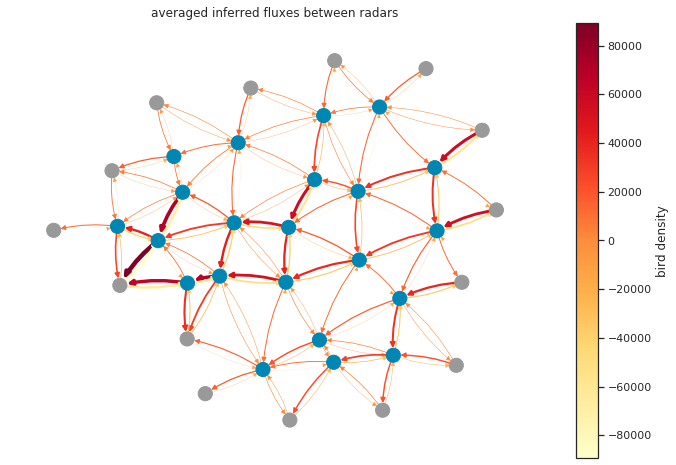

In [21]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[1], results3, trial=0, encoder=1, context=24, bird_scale=bird_scales3['BirdFluxGraphLSTM'])

(array([ 0,  0,  0, ..., 36, 36, 36]), array([10, 10, 10, ...,  6,  6,  6]), array([  10,   11,   12, ..., 3194, 3195, 3196]))


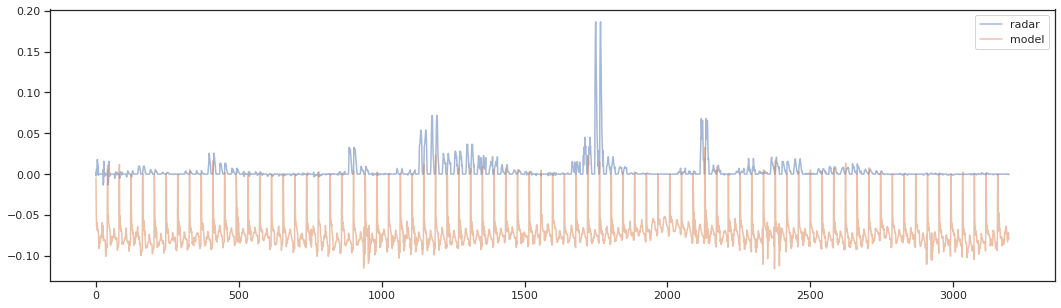

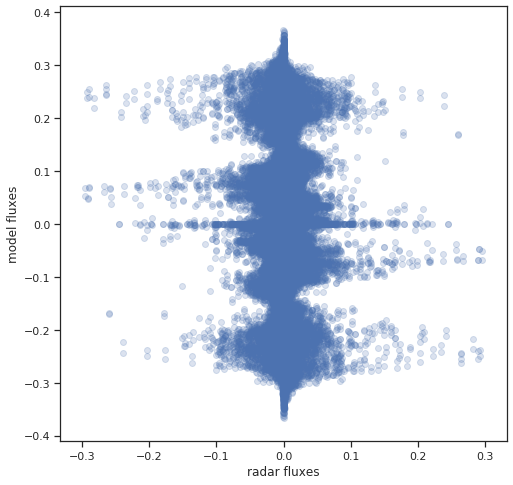

In [129]:
compare_fluxes(voronoi.index.values, fluxes3[0], fluxes3[1], trial=0, context=24, src=10, dst=9)

In [273]:
models = ['LocalLSTM', 'testFluxMLP']
experiments = ['encoder_km2',
              'test_batch4_n_hidden64_x_i']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


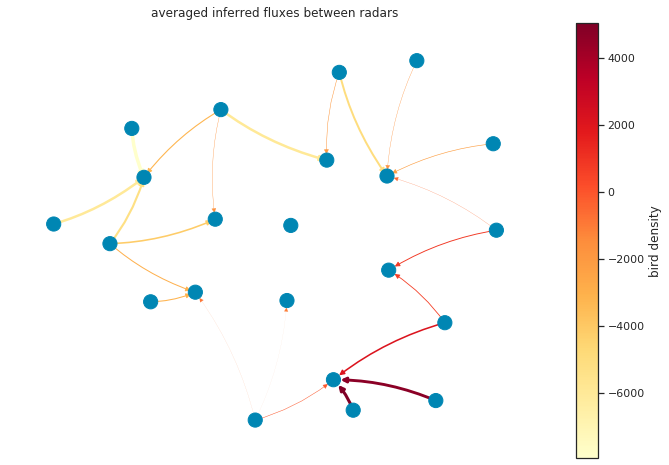

In [274]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2016/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2016/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='testFluxMLP')

In [221]:
ridx

{'LocalLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'},
 'BirdFluxGraphLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'}}

2.849597573506007e-05


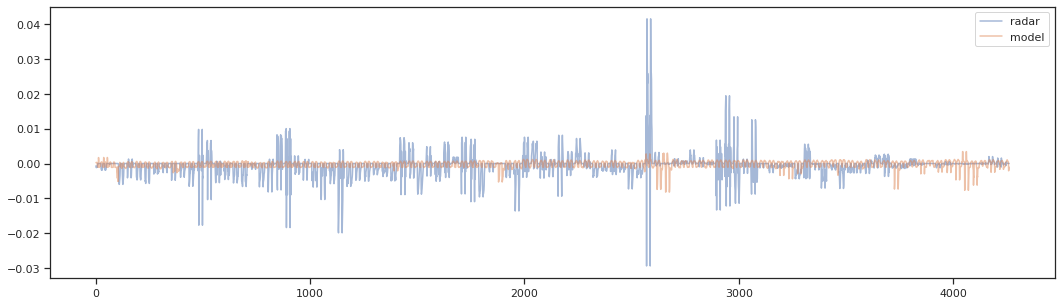

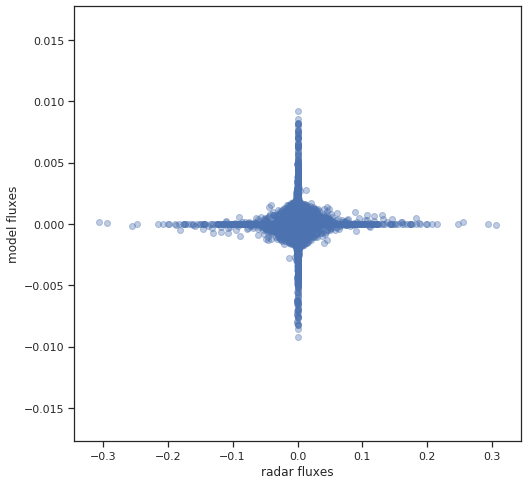

In [277]:
compare_fluxes(voronoi.index.values, fluxes2[0], fluxes2[1], trial=0, context=24, src=19, dst=20)

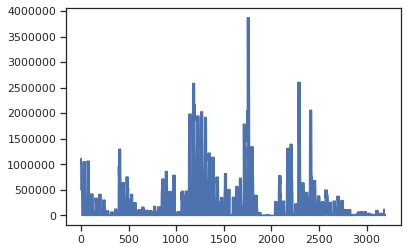

In [257]:
plt.plot(results2['testFluxMLP'].query('radar == "deneu"')['gt'].values)